<a href="https://colab.research.google.com/github/a-brhian/Probabilidade_e_Estatistica/blob/main/Teste%20De%20Hip%C3%B3tes%20e%20ANOVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Teste de Hipótese e ANOVA

Certos experimentos exigem uma metodologia que garanta se uma amostra contém ou não um determinado parâmetro, que pode ser, por exemplo, uma média, uma proporção, uma variância ou outro parâmetro de interesse.

Esse tipo de problema é exatamente o que o Teste de Hipóteses busca resolver. Por meio dele, é possível verificar se uma amostra possui um determinado valor (chamado de hipótese nula, representada por $H_0$) ou não (caso em que se considera a hipótese alternativa, representada por $H_1$ ou $H_A$).

Para ilustrar como realizar um Teste de Hipóteses no `R`, vamos utilizar dados relacionados à produção do fermentado da fruta mapati, típica da região Amazônica, os quais embasaram a seguinte publicação:

> Araújo, T. E. C. de, Menezes, V. da S., Oliveira, F. K. A. de, Bezerra, J. de A., Kinupp, V. F., Silva, A. B. de S. M., & Boeira, L. S. (2025). Desenvolvimento do processo de produção do fermentado de mapati (Pourouma cecropiifolia): a uva da Amazônia. OBSERVATÓRIO DE LA ECONOMÍA LATINOAMERICANA, 23(5), e9842. https://doi.org/10.55905/oelv23n5-031

## Dados

Vamos considerar a capacidade antioxidante que foi determinada através do ensaio com o radical DPPH  (2,2-difenil-1-picril-hidrazil),  100μL  da  amostra  foi  adicionado  a  3,9  mL  de solução de DPPH (100μM) e incubado em ambiente escuro por 30 minutos. Isso foi aplicado para 12 tipos diferentes de fermentados do mapati.

Vamos carregar os dados abaixo


In [1]:
#-------------------------------------------
# INSTITUTO FEDERAL DE EDUCACAO, CIENCIA E TECNOLOGIA DO AMAZONAS
#
# CREATED BY: ALYSSON BRHIAN DE SOUZA MUNIZ SILVA
# DATA: 06/07/2025
# VERSION OF R: 4.5.1
#
# GOAL: Capítulo 8 e 12 do Devore
#rm(list=ls());gc();setwd(path_name);save.image("???.RData")
#---------------------------------------------
R.version.string

[1] "R version 4.5.1 (2025-06-13)"

In [20]:
require(readxl)

dados <- read_excel("/content/dpph.xlsx", skip = 1, sheet = "Planilha")

head(dados);tail(dados)
dim(dados)

attach(dados)

Levedura,DPPH
<chr>,<dbl>
Cuvee,1661.0
Cuvee,1656.0
Cuvee,1668.5
Bbay,1738.5
Bbay,1733.5
Bbay,1773.5


Levedura,DPPH
<chr>,<dbl>
FERMOL,1581.0
FERMOL,1573.5
FERMOL,1578.5
CB,1646.0
CB,1658.5
CB,1663.5


[1] 36  2

The following objects are masked from dados (pos = 6):

    DPPH, Levedura




[1] 1665.236

Antes de trabalhar com qualquer método estatístico, sempre se recomenda fazer uma "Análise Exploratória de Dados" (AED).

Para esse tipo de dados, vamos primeiro fazer um boxplot e depois verificar as estatísticas para esses dados.

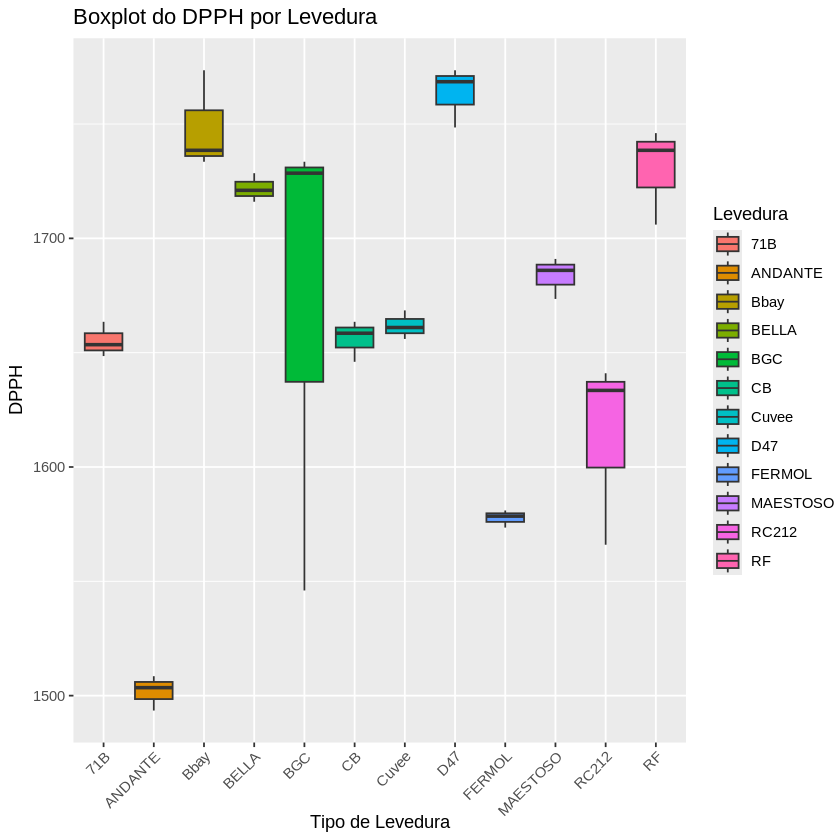

In [16]:
require(ggplot2)

ggplot(dados, aes(x = Levedura, y = DPPH, fill = Levedura)) +
  geom_boxplot() +
  labs(title = "Boxplot do DPPH por Levedura",
       x = "Tipo de Levedura",
       y = "DPPH") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) # Rotaciona os rótulos do eixo x para melhor visualização

In [19]:
#install.packages("moments")

require(dplyr)
require(moments)

resumo_levedura <- dados %>%
  group_by(Levedura) %>%
  summarise(
    Minimo = min(DPPH),
    Q1 = quantile(DPPH, 0.25),
    Mediana = median(DPPH),
    Media = mean(DPPH),
    Q3 = quantile(DPPH, 0.75),
    Maximo = max(DPPH),
    Desvio_Padrao = sd(DPPH),
    Assimetria = skewness(DPPH),
    Curtose = kurtosis(DPPH)
  )

print(resumo_levedura)

# A tibble: 12 × 10
   Levedura Minimo    Q1 Mediana Media    Q3 Maximo Desvio_Padrao Assimetria
   <chr>     <dbl> <dbl>   <dbl> <dbl> <dbl>  <dbl>         <dbl>      <dbl>
 1 71B       1648. 1651    1654. 1655. 1658.  1664.          7.64      0.382
 2 ANDANTE   1493. 1498.   1503. 1502. 1506   1508.          7.64     -0.382
 3 BELLA     1716  1718.   1721  1722. 1725.  1728.          6.29      0.239
 4 BGC       1546  1637.   1728. 1669. 1731   1734.        107.       -0.705
 5 Bbay      1734. 1736    1738. 1748. 1756   1774.         21.8       0.665
 6 CB        1646  1652.   1658. 1656  1661   1664.          9.01     -0.470
 7 Cuvee     1656  1658.   1661  1662. 1665.  1668.          6.29      0.239
 8 D47       1748. 1758.   1768. 1764. 1771   1774.         13.2      -0.595
 9 FERMOL    1573. 1576    1578. 1578. 1580.  1581           3.82     -0.382
10 MAESTOSO  1674. 1680.   1686  1684. 1688.  1691           9.01     -0.470
11 RC212     1566  1600.   1633. 1613. 1637.  1641      

Podemos verificar que o valor do DPPH ($\mu$M ET) varia entre 1566 e 1774. Ao analisar os dados, observamos que algumas das 12 leveduras parecem ter valores semelhantes (por exemplo, Cuvee, FERMOL), outras apresentam alto DPPH (como D47 e Bbay), enquanto outras parecem ter baixo DPPH (a exemplo de ANDANTE e RC212). Além disso, certas leveduras demonstram maior variabilidade nos valores de DPPH, como é o caso de BGC e Bbay.

## Teste de Hipótese: Média

Vamos imaginar que um pesquisar descobriu em trabalhos anteriores, que o o DPPH médio para esse tipo de fermentado é de aproximadamente 1600. Porém, ele está interessado em saber se o fermentado *RC212* apresenta essa média ou não. A AED mostra que esse fermentado apresenta uma média de 1613, porém o boxplot mostra que a maioria desses dados está acima de 1613, e o pesquisado precisa confirmar se a amostra apresenta uma média de 1613 ao nível de significância de 5%.

Antes disso, precisamos contruir o Teste de Hipótese:


$$
\begin{cases}
H_0: \mu = 1600 \\
H_A: \mu > 1600
\end{cases}
$$



In [26]:
# Filtrar os dados para a levedura RC212
dados_rc212 <- dados %>%
  filter(Levedura == "RC212")

# Realizar o teste t de uma amostra
teste_t_rc212 <- t.test(dados_rc212$DPPH, mu = 1600, alternative = "greater", conf.level = 0.95)

# Imprimir os resultados do teste
print(teste_t_rc212)


	One Sample t-test

data:  dados_rc212$DPPH
t = 0.56607, df = 2, p-value = 0.3142
alternative hypothesis: true mean is greater than 1600
95 percent confidence interval:
 1543.863      Inf
sample estimates:
mean of x 
   1613.5 



Como o `p-value = 0.4926` é maior que o nível de significânica, então **rejeitamos** a *hipótese nula*, isto é, a amostra apresenta evicências de que o DPPH do fermentado RC212 é maior do que 1600 ao nível de significância de 5%.

E se testarmos ao nível de significância de 1%?

In [27]:
print(t.test(dados_rc212$DPPH, mu = 1600, alternative = "greater", conf.level = 0.99))


	One Sample t-test

data:  dados_rc212$DPPH
t = 0.56607, df = 2, p-value = 0.3142
alternative hypothesis: true mean is greater than 1600
99 percent confidence interval:
 1447.406      Inf
sample estimates:
mean of x 
   1613.5 



Encontramos o mesmo tipo de conclusão ao nível de significância de 1%.

# Análise de Variância (ANOVA)

Considere que um pesquisador deseja saber se uma quantidade de tratamentos diferentes diferem entre si em valores médios a um determinado tipo de significância. Para isso, podemos usar o Teste da Análise de Variância (ANOVA) para alcançar esse tipo de conclusão.

Para aplicar a ANOVA e garantir a validade dos resultados, algumas suposições sobre os dados devem ser atendidas:

1.  **Independência das Observações:** As observações dentro de cada grupo e entre os grupos devem ser independentes umas das outras. Isso geralmente é garantido pelo desenho experimental.

2.  **Normalidade dos Resíduos:** Os resíduos (as diferenças entre os valores observados e as médias dos grupos) devem seguir uma distribuição normal para cada grupo. Podemos verificar essa suposição usando testes estatísticos (como o teste de Shapiro-Wilk) ou gráficos (como histogramas ou Q-Q plots dos resíduos).

3.  **Homogeneidade das Variâncias (Homocedasticidade):** A variância dos resíduos deve ser aproximadamente igual para todos os grupos. Em outras palavras, a dispersão dos dados em torno da média deve ser semelhante em todos os níveis do fator. Podemos verificar essa suposição usando testes estatísticos (como o teste de Levene ou o teste de Bartlett) ou inspecionando os boxplots.

É importante notar que a ANOVA é relativamente robusta a pequenas violações das suposições de normalidade e homogeneidade de variâncias, especialmente quando os tamanhos das amostras são iguais ou grandes. No entanto, grandes violações podem levar a conclusões incorretas. Se as suposições não forem atendidas, pode ser necessário transformar os dados ou usar métodos não paramétricos.

No artigo que estamos trabalhando, vamos supor que os dados atendem todas essas considerções anteriores. Com isso dito, podemos compreender que os autores desejaram saber quais fermentados do mapati tinham características médias de DPPH parecidas entre si. Mas para isso, eles necessitavam anteriormente mostrar que os valores de DPPH não eram iguais entre si, ou seja:

$$
\begin{cases}
H_0: \mu_{71B} = \mu_{ANDANTE} = ... = \mu_{RF} \\
H_A: \text{pelo menos um } \mu \text{ é diferente}
\end{cases}
$$

Para fazer esse tipo de teste, nescecitamos utilizar os seguintes códigos em `R`:

In [28]:
# Realizar a Análise de Variância (ANOVA)
modelo_anova <- aov(DPPH ~ Levedura, data = dados)

# Resumo da ANOVA
summary(modelo_anova)

            Df Sum Sq Mean Sq F value   Pr(>F)    
Levedura    11 184806   16801   13.81 7.75e-08 ***
Residuals   24  29192    1216                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Com base na saída do `summary(modelo_anova)`, podemos interpretar os resultados da seguinte forma:

*   **Df (Graus de Liberdade):**
    *   `Levedura`: 11. Este é o número de graus de liberdade para o fator "Levedura". É calculado como o número de níveis no fator (12 leveduras) menos 1 (12 - 1 = 11).
    *   `Residuals`: 24. Este é o número de graus de liberdade residual (dentro dos grupos). É calculado como o número total de observações (36) menos o número de grupos (12) (36 - 12 = 24).

*   **Sum Sq (Soma dos Quadrados):**
    *   `Levedura`: 184806. Esta é a soma dos quadrados entre os grupos (ou explicada pela Levedura). Representa a variação total nas médias de DPPH que é atribuída às diferenças entre os tipos de levedura.
    *   `Residuals`: 29192. Esta é a soma dos quadrados residual (ou dentro dos grupos). Representa a variação dentro de cada grupo de levedura que não é explicada pelo tipo de levedura.

*   **Mean Sq (Quadrado Médio):**
    *   `Levedura`: 16801. Este é o quadrado médio entre os grupos. É calculado como a Soma dos Quadrados da Levedura dividida por seus graus de liberdade (184806 / 11 ≈ 16801).
    *   `Residuals`: 1216. Este é o quadrado médio residual (Erro Quadrático Médio - EQM). É calculado como a Soma dos Quadrados Residual dividida por seus graus de liberdade (29192 / 24 ≈ 1216). Representa a variância média dentro de cada grupo.

*   **F value (Valor F):** 13.81. Este é o valor da estatística F. É a razão entre o quadrado médio da Levedura e o quadrado médio residual (16801 / 1216 ≈ 13.81). Um valor F grande indica que a variação entre as médias dos grupos é grande em comparação com a variação dentro dos grupos.

*   **Pr(>F) (p-valor):** 7.75e-08. Este é o p-valor associado ao valor F. Ele representa a probabilidade de observar uma estatística F tão extrema (ou mais extrema) quanto a calculada, assumindo que a hipótese nula (todas as médias de DPPH são iguais) é verdadeira. Um p-valor muito pequeno (como 7.75e-08) sugere que é altamente improvável observar os dados se a hipótese nula for verdadeira.

*   **Signif. codes (Códigos de Significância):** As estrelas (`***`) indicam o nível de significância estatística. `***` corresponde a um p-valor < 0.001.

**Conclusão:**

Como o p-valor (7.75e-08) é muito menor do que o nível de significância comum de 5% (ou até mesmo 0,01%), rejeitamos a hipótese nula. Isso significa que há evidências estatísticas fortes para concluir que pelo menos uma das médias de DPPH entre os diferentes tipos de levedura é significativamente diferente das outras, ao nível de significância de 5%.

Sabendo que pelo menos uma das médias de DPPH entre os diferentes tipos de levedura é significativamente diferente das outras, buscou-se verificar quais leveduras tinham DPPH parecidos entre si por meio do *Teste de Tukey*. Os resultados e discussões desses resultados estão apresentados na Tabela 3 e ao longo do artigo (ARAÚJO, *et. al.*, 2025).